In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

In [2]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

In [3]:
import torch
import torch.nn as nn
from tqdm import tqdm

# 1D Black-Scholes Model, Bermudan Put Option

Let $(S_t)_{t \in [0,T]}$ be a Black-Scholes (geometric Brownian motion) process with parameters $r$, $\sigma$, and initial value $x_0 > 0$, that is,
$$
    S_t = x_0 e^{(r-\frac{\sigma^2}{2}) t + \sigma W_t}
$$
where $(W_t)_{t \in [0,T]}$ is a standard Brownian motion.

We consider fixed discrete dates $t_n = n \frac{T}{N}$ for $n = 0, \dots, N$. The asset value at the times $t_n$ forms a Markov chain denoted by $(X_n)_{n = 0,\dots,N}$, that is,
$$
    \forall n=0, \dots, N, \quad X_n = S_{t_n}
$$
The Bermudan put option is an option that can be exercised at any date $t_n$. If exercised at $t_n$, the associated payoff is
$$
    Z_n = \varphi(n, X_n) = e^{-r n \frac{T}{N}} (K - X_n)_+.
$$

We are interested in the discrete-time optimal stopping problem
$$
    V_0(x_0) = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ Z_\tau \big]
    = \sup_{\tau \in \mathcal{T}_0} \mathbf{E}\big[ \varphi(\tau, X_\tau) \big],
$$
where $\mathcal{T}_0$ is the set of stopping times taking values in $\{0,\dots,N\}$.


In [4]:
r = 0.1
sigma = 0.25
x0 = 100
K = 110
N, T = 10, 1

In [5]:
def simu_BS1d(size_path, size_sample): 
    h = T/size_path
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(size_path, size_sample))
    sample = np.zeros(shape=(size_path+1, size_sample))
    sample[0] = x0
    for n in range(1, size_path+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [6]:
def payoff_phi(n, x): 
    return np.exp(-r*n*T/N) * np.maximum(K-x, 0)

In [7]:
M = 2**20
sample_X = simu_BS1d(N, M)
payoffs_Z = np.empty_like(sample_X)
for n in range(0, N+1):
    payoffs_Z[n] = payoff_phi(n, sample_X[n])

In [8]:
sample_X.shape 

(11, 1048576)

In [9]:
payoffs_Z.shape

(11, 1048576)

# Feedforward Neural Network

We consider the parametric function, for a fixed $L \ge 2$, defined as a composition of functions
$$
    \Phi(x; \theta) = A_L \circ \big( \sigma \circ A_{L-1} \big) \circ \cdots \circ \big( \sigma \circ A_1 \big)(x)
$$
with $\theta = \big( W_\ell, \beta_\ell \big)_{1 \le \ell \le L}$, and for each $\ell \in \{1,\dots,L\}$, the affine function $A_\ell$ is given by $A_\ell(x) = W_\ell x + \beta_\ell$. The function $\sigma$ denotes the ReLU activation function.


In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size):
        super().__init__()
        layers = [ nn.Linear(input_size, layer_sizes[0]),
                   nn.ReLU() ]
        for (ls_in, ls_out) in zip(layer_sizes, layer_sizes[1:]):
            layers.append(nn.Linear(ls_in, ls_out))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(layer_sizes[-1], output_size))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [11]:
phi = NeuralNetwork(input_size=1, layer_sizes=[16, 16], output_size=1)

In [12]:
phi

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [13]:
#device = "mps" if torch.mps.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


## Definition of a `learning` Function — **Data-Based** Approach

In [14]:
def theta_by_learning(xj, yj, layer_sizes, n_epochs, batch_size, 
                      learning_rate=1e-3, 
                      theta_init=None, device=device):
    data_size, input_size = xj.shape
    n_upd = data_size // batch_size 
    
    phi = NeuralNetwork(input_size, layer_sizes, output_size=1).to(device)
    if theta_init is not None:
        phi.load_state_dict(theta_init.copy())
    optimizer = torch.optim.Adam(phi.parameters(), lr=learning_rate)
    
    with tqdm(range(n_epochs)) as nrange:
        for n in nrange:
            indexes = torch.randperm(data_size)
            for k in range(n_upd):
                idx = indexes[ k*batch_size : (k+1)*batch_size ] 
                loss = ((yj[idx] - phi(xj[idx]))**2).mean()
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            nrange.set_postfix(loss=loss.item())
    return phi.state_dict(), phi(xj)

# Longstaff-Schwartz Algorithm

In [15]:
xj_path = torch.from_numpy(sample_X.astype(np.float32)).to(device).float()
yj_path = torch.from_numpy(payoffs_Z.astype(np.float32)).to(device).float()

In [16]:
cst_norm = xj_path.mean(), xj_path.std(), yj_path.mean(), yj_path.std()
x_mean, x_std, y_mean, y_std = cst_norm

def normalize_x(xi):
    return (xi-x_mean)/x_std
def normalize(xi, yi):
    return (xi-x_mean)/x_std, (yi-y_mean)/y_std 
def unnormalize(xi, yi):
    return xi*x_std + x_mean, yi*y_std + y_mean 

In [17]:
xj_path, yj_path = normalize(xj_path, yj_path)

In [18]:
layer_sizes = [32, 16]
phi = NeuralNetwork(1, layer_sizes, 1).to(device)
theta_n = phi.state_dict()
thetas = []

payoff_opt = yj_path[N].clone()
for n in reversed(range(1, N)):
    print("learning at timestep:", n)
    theta_n, cont_value_n =  theta_by_learning(xj_path[n][:,None], payoff_opt[:,None], 
                                               layer_sizes, 
                                               40 if n == N-1 else 5, 
                                               2*1024, theta_init = theta_n)
    thetas.insert(0, theta_n)
    stop_at_n = yj_path[n,:] >= cont_value_n.flatten()
    payoff_opt[stop_at_n] = yj_path[n, stop_at_n].clone()

learning at timestep: 9


100%|███████████████████████████████| 40/40 [02:51<00:00,  4.30s/it, loss=0.189]


learning at timestep: 8


100%|█████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it, loss=0.232]


learning at timestep: 7


100%|█████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it, loss=0.285]


learning at timestep: 6


100%|█████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it, loss=0.338]


learning at timestep: 5


100%|█████████████████████████████████| 5/5 [00:20<00:00,  4.06s/it, loss=0.383]


learning at timestep: 4


100%|█████████████████████████████████| 5/5 [00:20<00:00,  4.14s/it, loss=0.461]


learning at timestep: 3


100%|█████████████████████████████████| 5/5 [00:23<00:00,  4.60s/it, loss=0.495]


learning at timestep: 2


100%|█████████████████████████████████| 5/5 [00:18<00:00,  3.64s/it, loss=0.589]


learning at timestep: 1


100%|█████████████████████████████████| 5/5 [00:20<00:00,  4.19s/it, loss=0.679]


In [19]:
def continuation(n, xx):
    xx_ = normalize_x(xx)
    phi.load_state_dict(thetas[n-1])
    xx, yy = unnormalize(xx_ , phi(xx_))
    return yy.numpy()

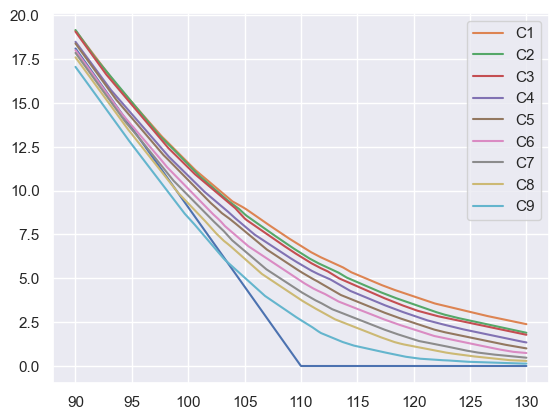

In [20]:
xx = torch.linspace(90, 130, 1000)[:,None].float()
fig, ax = plt.subplots()
with torch.no_grad():
    ax.plot(xx, payoff_phi(N, xx.numpy()))
    for n in range(1, N):
        ax.plot(xx, continuation(n, xx), label=fr"C{n}")
plt.legend()
plt.show()

In [21]:
sample = y_mean + payoff_opt*y_std
monte_carlo(sample.detach().numpy().flatten())

{'mean': np.float32(11.977382),
 'var': np.float32(84.7854),
 'lower': np.float64(11.959757535733116),
 'upper': np.float64(11.99500587674247)}

In [22]:
# thetas

# Repricing on New Trajectories

In [23]:
def simu_data_torch(size_sample, device=device): 
    h = T/N
    brown_acc = np.sqrt(h)*torch.randn(size=(N, size_sample), device=device)
    sample_X = torch.zeros(size=(N+1, size_sample))
    sample_X[0] = x0
    for n in range(1, N+1):
        sample_X[n] = sample_X[n-1] * torch.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])

    payoffs_Z = torch.empty_like(sample_X)
    for n in range(0, N+1):
        payoffs_Z[n] = np.exp(-r*n*h) * torch.relu(K-sample_X[n])
    return normalize(sample_X, payoffs_Z)

In [24]:
sample_size = 2**22
xj_path, yj_path = simu_data_torch(sample_size)

In [25]:
payoff_opt = yj_path[N].clone()
for n in reversed(range(1, N)):
    phi.load_state_dict(thetas[n-1])
    with torch.no_grad():
        cont_at_n = phi(xj_path[n,:][:,None]).flatten()
    stop_at_n = yj_path[n,:] >= cont_at_n
    payoff_opt[stop_at_n] = yj_path[n, stop_at_n].clone()

In [26]:
sample = y_mean + payoff_opt*y_std
monte_carlo(sample.detach().numpy().flatten())

{'mean': np.float32(11.981017),
 'var': np.float32(84.65418),
 'lower': np.float64(11.972211849757752),
 'upper': np.float64(11.989822375706115)}